In [1]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv
load_dotenv()
assert 'OPENAI_API_KEY' in os.environ

In [2]:
import dspy
turbo = dspy.OpenAI(model='gpt-3.5-turbo', max_tokens=4000)
gpt4 = dspy.OpenAI(model='gpt-4', max_tokens=4000)
dspy.settings.configure(lm=turbo)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dspy.TypedPredictor("question -> answer")(question="What is the capital of France?")

Prediction(
    answer='Paris'
)

In [4]:
from dspy.datasets import HotPotQA

# Load the dataset.
dataset = HotPotQA(train_seed=1, train_size=20, eval_seed=2023, dev_size=50, test_size=0)

# Tell DSPy that the 'question' field is the input. Any other fields are labels and/or metadata.
trainset = [x.with_inputs('question') for x in dataset.train]
devset = [x.with_inputs('question') for x in dataset.dev]

len(trainset), len(devset)

(20, 50)

In [5]:
class BasicQA(dspy.Signature):
    """Answer questions with short factoid answers."""

    question = dspy.InputField()
    answer = dspy.OutputField(desc="often between 1 and 5 words")

In [6]:
from dspy.evaluate import Evaluate
from dspy.evaluate.metrics import answer_exact_match
from dspy.functional import TypedPredictor
from dspy.teleprompt.signature_opt_typed import optimize_signature

evaluator = Evaluate(devset=devset, metric=answer_exact_match, num_threads=10, display_progress=True)

result = optimize_signature(
    student=TypedPredictor(BasicQA),
    evaluator=evaluator,
    initial_prompts=6,
    n_iterations=100,
    max_examples=30,
    verbose=True,
    prompt_model=gpt4,
)

Found 1 typed predictors to optimize.
Generating 6 initial signatures for base...

Running eval iteration 0...


Average Metric: 16 / 50  (32.0): 100%|██████████| 50/50 [00:00<00:00, 3086.59it/s]
/Users/ahle/repos/dspy/dspy/evaluate/evaluate.py:145: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


Average Metric: 16 / 50  (32.0%)

Running eval iteration 1...


Average Metric: 1 / 50  (2.0): 100%|██████████| 50/50 [00:00<00:00, 1268.65it/s]


Average Metric: 1 / 50  (2.0%)

Running eval iteration 2...


Average Metric: 17 / 50  (34.0): 100%|██████████| 50/50 [00:00<00:00, 1031.35it/s]


Average Metric: 17 / 50  (34.0%)

Running eval iteration 3...


Average Metric: 16 / 50  (32.0): 100%|██████████| 50/50 [00:00<00:00, 1364.88it/s]


Average Metric: 16 / 50  (32.0%)

Running eval iteration 4...


Average Metric: 6 / 50  (12.0): 100%|██████████| 50/50 [00:00<00:00, 892.68it/s]


Average Metric: 6 / 50  (12.0%)

Running eval iteration 5...


Average Metric: 5 / 50  (10.0): 100%|██████████| 50/50 [00:00<00:00, 1055.56it/s]


Average Metric: 5 / 50  (10.0%)

Running eval iteration 6...


Average Metric: 12 / 50  (24.0): 100%|██████████| 50/50 [00:00<00:00, 942.15it/s]


Average Metric: 12 / 50  (24.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 7 to avoid.

Running eval iteration 7...


Average Metric: 17 / 50  (34.0): 100%|██████████| 50/50 [00:00<00:00, 1054.12it/s]


Average Metric: 17 / 50  (34.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 8 to avoid.

Running eval iteration 8...


Average Metric: 17 / 50  (34.0): 100%|██████████| 50/50 [00:00<00:00, 957.29it/s]


Average Metric: 17 / 50  (34.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 9 to avoid.

Running eval iteration 9...


Average Metric: 12 / 50  (24.0): 100%|██████████| 50/50 [00:00<00:00, 1015.95it/s]


Average Metric: 12 / 50  (24.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 10 to avoid.

Running eval iteration 10...


Average Metric: 11 / 50  (22.0): 100%|██████████| 50/50 [00:00<00:00, 839.64it/s]


Average Metric: 11 / 50  (22.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 11 to avoid.

Running eval iteration 11...


Average Metric: 15 / 50  (30.0): 100%|██████████| 50/50 [00:00<00:00, 833.32it/s]


Average Metric: 15 / 50  (30.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 12 to avoid.

Running eval iteration 12...


Average Metric: 15 / 50  (30.0): 100%|██████████| 50/50 [00:00<00:00, 1105.97it/s]


Average Metric: 15 / 50  (30.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 13 to avoid.

Running eval iteration 13...


Average Metric: 17 / 50  (34.0): 100%|██████████| 50/50 [00:00<00:00, 1112.59it/s]


Average Metric: 17 / 50  (34.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 14 to avoid.

Running eval iteration 14...


Average Metric: 17 / 50  (34.0): 100%|██████████| 50/50 [00:00<00:00, 1096.58it/s]


Average Metric: 17 / 50  (34.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 15 to avoid.

Running eval iteration 15...


Average Metric: 16 / 50  (32.0): 100%|██████████| 50/50 [00:00<00:00, 1092.70it/s]


Average Metric: 16 / 50  (32.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 16 to avoid.

Running eval iteration 16...


Average Metric: 16 / 50  (32.0): 100%|██████████| 50/50 [00:00<00:00, 1097.79it/s]


Average Metric: 16 / 50  (32.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 17 to avoid.

Running eval iteration 17...


Average Metric: 17 / 50  (34.0): 100%|██████████| 50/50 [00:00<00:00, 547.69it/s]


Average Metric: 17 / 50  (34.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 18 to avoid.

Running eval iteration 18...


Average Metric: 16 / 50  (32.0): 100%|██████████| 50/50 [00:00<00:00, 964.67it/s]


Average Metric: 16 / 50  (32.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 19 to avoid.

Running eval iteration 19...


Average Metric: 19 / 50  (38.0): 100%|██████████| 50/50 [00:00<00:00, 1014.22it/s]


Average Metric: 19 / 50  (38.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 20 to avoid.

Running eval iteration 20...


Average Metric: 16 / 50  (32.0): 100%|██████████| 50/50 [00:00<00:00, 906.14it/s]


Average Metric: 16 / 50  (32.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 21 to avoid.

Running eval iteration 21...


Average Metric: 17 / 50  (34.0): 100%|██████████| 50/50 [00:00<00:00, 1017.81it/s]


Average Metric: 17 / 50  (34.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 22 to avoid.

Running eval iteration 22...


Average Metric: 19 / 50  (38.0): 100%|██████████| 50/50 [00:00<00:00, 1032.48it/s]


Average Metric: 19 / 50  (38.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 23 to avoid.

Running eval iteration 23...


Average Metric: 15 / 50  (30.0): 100%|██████████| 50/50 [00:00<00:00, 726.33it/s]


Average Metric: 15 / 50  (30.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 24 to avoid.

Running eval iteration 24...


Average Metric: 15 / 50  (30.0): 100%|██████████| 50/50 [00:00<00:00, 957.55it/s]


Average Metric: 15 / 50  (30.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 25 to avoid.

Running eval iteration 25...


Average Metric: 16 / 50  (32.0): 100%|██████████| 50/50 [00:00<00:00, 1009.53it/s]


Average Metric: 16 / 50  (32.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 26 to avoid.

Running eval iteration 26...


Average Metric: 15 / 50  (30.0): 100%|██████████| 50/50 [00:00<00:00, 1064.53it/s]


Average Metric: 15 / 50  (30.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 27 to avoid.

Running eval iteration 27...


Average Metric: 18 / 50  (36.0): 100%|██████████| 50/50 [00:00<00:00, 1052.90it/s]


Average Metric: 18 / 50  (36.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 28 to avoid.

Running eval iteration 28...


Average Metric: 20 / 50  (40.0): 100%|██████████| 50/50 [00:00<00:00, 731.18it/s]


Average Metric: 20 / 50  (40.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 29 to avoid.

Running eval iteration 29...


Average Metric: 16 / 50  (32.0): 100%|██████████| 50/50 [00:02<00:00, 18.61it/s]
/Users/ahle/repos/dspy/dspy/evaluate/evaluate.py:145: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(truncate_cell)


Average Metric: 16 / 50  (32.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 30 to avoid.

Running eval iteration 30...


Average Metric: 17 / 50  (34.0): 100%|██████████| 50/50 [00:02<00:00, 18.23it/s]


Average Metric: 17 / 50  (34.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 31 to avoid.

Running eval iteration 31...


Average Metric: 19 / 50  (38.0): 100%|██████████| 50/50 [00:02<00:00, 20.82it/s]


Average Metric: 19 / 50  (38.0%)
Generating new signature for base...
Tested the signature, and it's not in the list of 32 to avoid.

Running eval iteration 32...


Average Metric: 17 / 49  (34.7):  98%|█████████▊| 49/50 [00:14<00:00, 20.66it/s]

Check the final program after optimization

In [ ]:
result.program

predictor = Predict(BasicQA(question -> answer
    instructions='Answer questions with short factoid answers.'
    question = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Question:', 'desc': '${question}'})
    answer = Field(annotation=str required=True json_schema_extra={'desc': 'often between 1 and 5 words', '__dspy_field_type': 'output', 'prefix': 'Answer:'})
))

Plot the scores over time

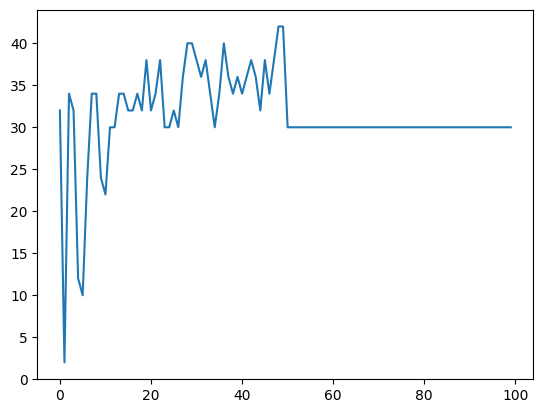

In [ ]:
import matplotlib.pyplot as plt
plt.plot(result.scores)

In [ ]:
gpt4.inspect_history(n=1)





You are an instruction optimizer for large language models.

I will give some task instructions I've tried, along with their corresponding validation scores.
- The instructions are arranged in order based on their scores, where higher scores indicate better quality.
- Your task is to propose a new instruction that will lead a good language model to perform the task even better.
- Be creative, and think out of the box.
- Don't repeat instructions, descriptions and prefixes that have already been attempted.

---

Follow the following format.

Analysis: Consider what made the previous instructions good or bad.
Proposed Signature: A signature that will likely lead to a high score.. Respond with a single JSON object. JSON Schema: {"properties": {"instructions": {"description": "The instructions for the task", "title": "Instructions", "type": "string"}, "question_prefix": {"description": "The prefix for question", "title": "Question Prefix", "type": "string"}, "question_desc": {"descript